In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sat Jan 27 00:09:15 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   40C    P0    46W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4_commit/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 7308
-rw-rw-r-- 1 scpark scpark    5554  1월 27 00:09 events.out.tfevents.1706281712.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7471539  1월 27 00:08 save_0


In [7]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

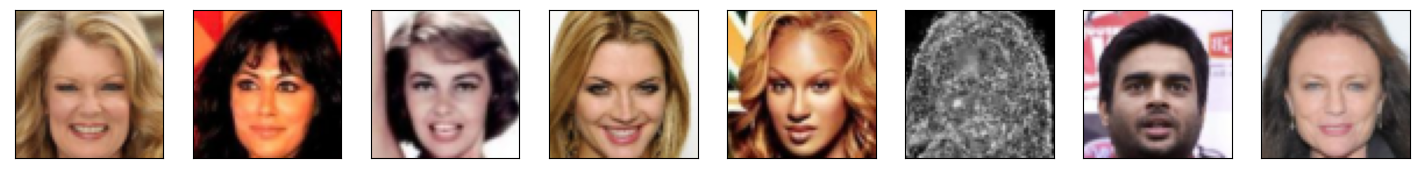

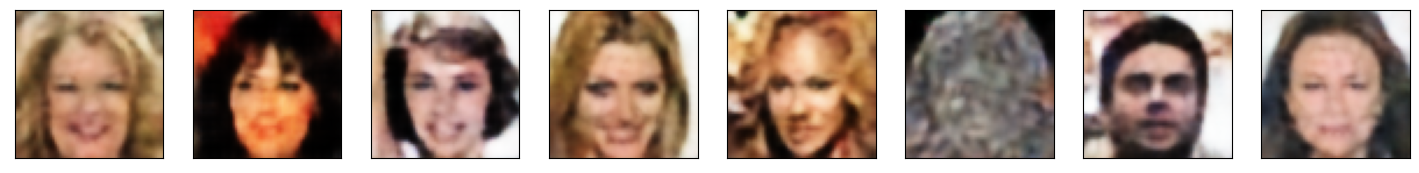

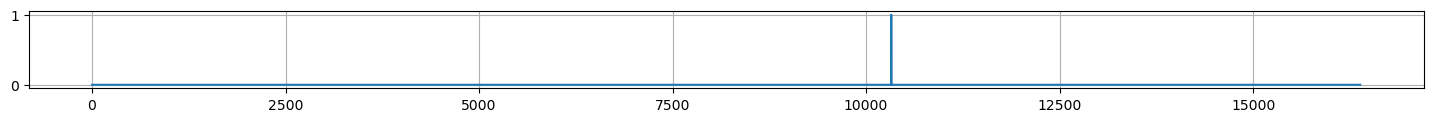

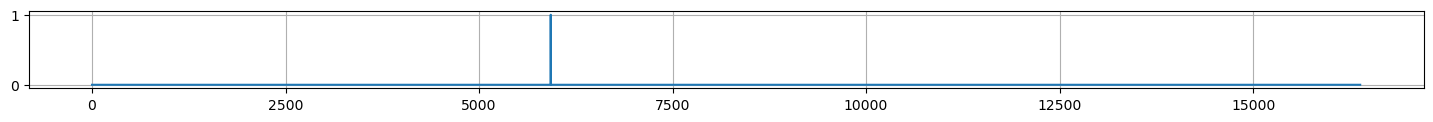

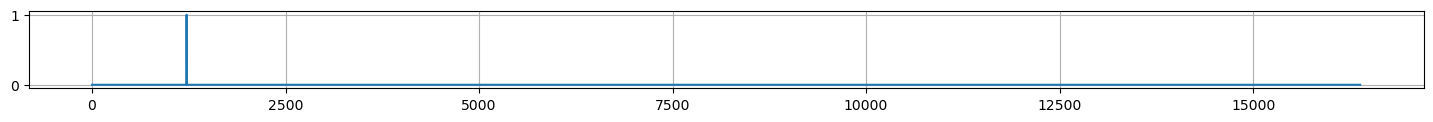

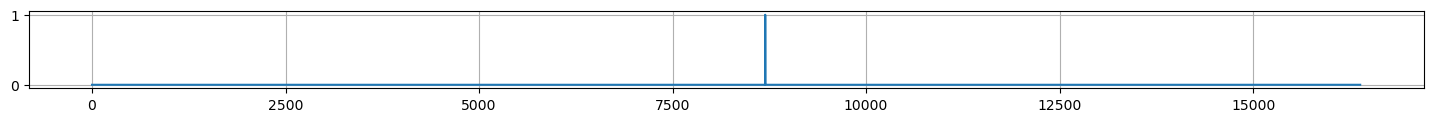

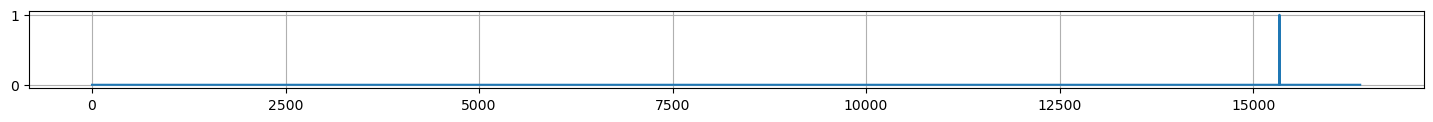

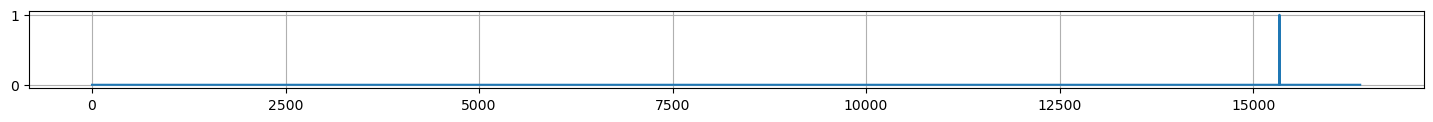

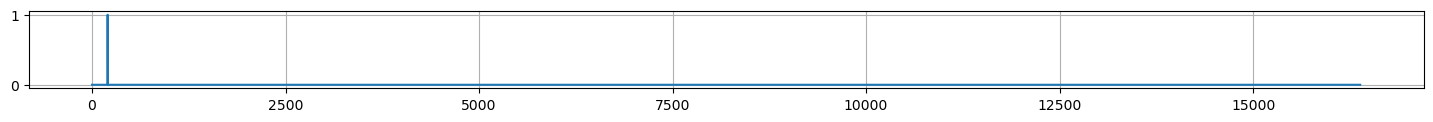

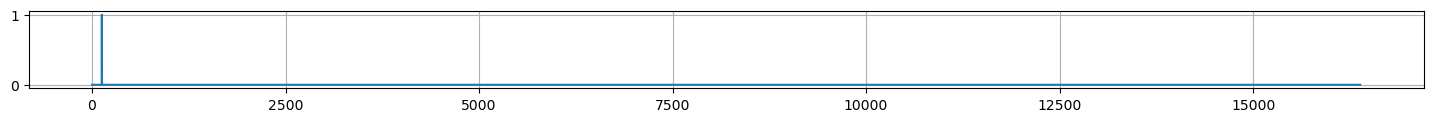

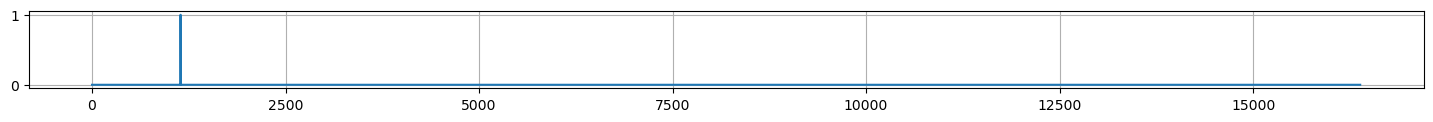

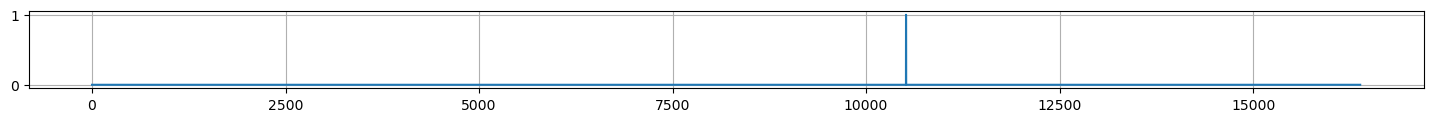

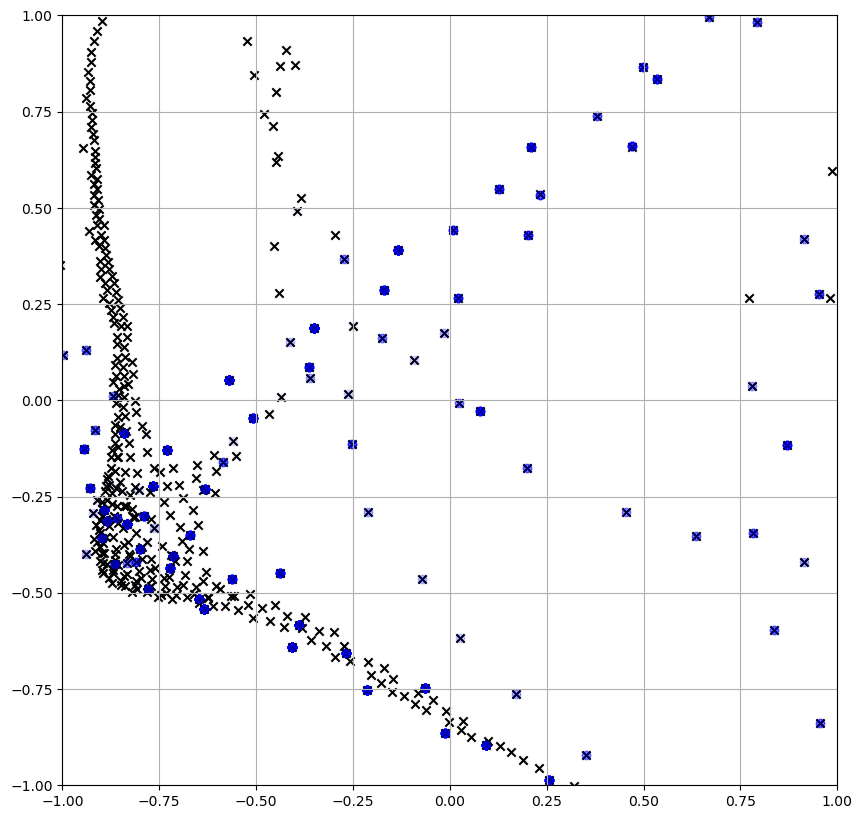

1001
lse_loss 57193.51953125
commit_loss 0.00236112205311656
recon_loss 0.0033474001102149487
1002
lse_loss 56112.54296875
commit_loss 0.002430558204650879
recon_loss 0.003278931602835655
1003
lse_loss 55491.43359375
commit_loss 0.0025130407884716988
recon_loss 0.00341902207583189
1004
lse_loss 55420.30859375
commit_loss 0.002416415372863412
recon_loss 0.0035578222014009953
1005
lse_loss 53389.98828125
commit_loss 0.0024863844737410545
recon_loss 0.0033286563120782375
1006
lse_loss 51262.39453125
commit_loss 0.002440675627440214
recon_loss 0.0034120911732316017
1007
lse_loss 55746.62890625
commit_loss 0.0024698120541870594
recon_loss 0.0033879063557833433
1008
lse_loss 57209.91015625
commit_loss 0.002848445437848568
recon_loss 0.004156205337494612
1009
lse_loss 51271.1796875
commit_loss 0.0032362984493374825
recon_loss 0.004347877576947212
1010
lse_loss 57404.41796875
commit_loss 0.002583695575594902
recon_loss 0.0037879589945077896
1011
lse_loss 55506.1015625
commit_loss 0.00243998807

1091
lse_loss 56189.953125
commit_loss 0.002507933648303151
recon_loss 0.003235223703086376
1092
lse_loss 61840.01953125
commit_loss 0.002470203209668398
recon_loss 0.0034455216955393553
1093
lse_loss 50361.37890625
commit_loss 0.0028963538352400064
recon_loss 0.003627957310527563
1094
lse_loss 61499.92578125
commit_loss 0.00276047270745039
recon_loss 0.003671815153211355
1095
lse_loss 61060.33203125
commit_loss 0.0024040737189352512
recon_loss 0.0030980666633695364
1096
lse_loss 57762.16015625
commit_loss 0.0027325674891471863
recon_loss 0.0032836836762726307
1097
lse_loss 54498.140625
commit_loss 0.0027840062975883484
recon_loss 0.0037069921381771564
1098
lse_loss 57227.296875
commit_loss 0.002650667680427432
recon_loss 0.0035208731424063444
1099
lse_loss 70031.6328125
commit_loss 0.0026998408138751984
recon_loss 0.0037785503081977367
1100
lse_loss 54757.17578125
commit_loss 0.0025925864465534687
recon_loss 0.0033873701468110085
1101
lse_loss 52829.46875
commit_loss 0.002551667857915

lse_loss 66542.9765625
commit_loss 0.0025261053815484047
recon_loss 0.0037423167377710342
1181
lse_loss 63038.546875
commit_loss 0.002813211875036359
recon_loss 0.0035421447828412056
1182
lse_loss 63703.44921875
commit_loss 0.0025893172714859247
recon_loss 0.0034211338497698307
1183
lse_loss 61520.328125
commit_loss 0.0025645270943641663
recon_loss 0.0034108113031834364
1184
lse_loss 63296.98046875
commit_loss 0.0026226697955280542
recon_loss 0.0034890759270638227
1185
lse_loss 53156.52734375
commit_loss 0.002456261310726404
recon_loss 0.0031453182455152273
1186
lse_loss 66860.21875
commit_loss 0.002520741429179907
recon_loss 0.0034912738483399153
1187
lse_loss 56458.62109375
commit_loss 0.0025286786258220673
recon_loss 0.0031983228400349617
1188
lse_loss 61771.1328125
commit_loss 0.002468548947945237
recon_loss 0.0033217966556549072
1189
lse_loss 61720.28515625
commit_loss 0.002549288794398308
recon_loss 0.003365481272339821
1190
lse_loss 61111.19140625
commit_loss 0.00241072964854538

1268
lse_loss 56491.1328125
commit_loss 0.0024215131998062134
recon_loss 0.0033716890029609203
1269
lse_loss 65901.6171875
commit_loss 0.0023046908900141716
recon_loss 0.0031969526316970587
1270
lse_loss 64083.27734375
commit_loss 0.0025275894440710545
recon_loss 0.003420882858335972
1271
lse_loss 66316.9453125
commit_loss 0.0024240799248218536
recon_loss 0.0037678312510252
1272
lse_loss 60802.8359375
commit_loss 0.0024599574971944094
recon_loss 0.0033001666888594627
1273
lse_loss 62360.7265625
commit_loss 0.0025598760694265366
recon_loss 0.0035759322345256805
1274
lse_loss 66993.9375
commit_loss 0.002672462025657296
recon_loss 0.0031557201873511076
1275
lse_loss 62048.8125
commit_loss 0.0024156952276825905
recon_loss 0.0032431676518172026
1276
lse_loss 65063.25390625
commit_loss 0.0023495210334658623
recon_loss 0.0031847867649048567
1277
lse_loss 54469.296875
commit_loss 0.002317204140126705
recon_loss 0.00280573358759284
1278
lse_loss 59000.171875
commit_loss 0.0024721291847527027
re

lse_loss 64298.76171875
commit_loss 0.002360845683142543
recon_loss 0.003111759200692177
1358
lse_loss 63578.4453125
commit_loss 0.00233547599054873
recon_loss 0.003339068964123726
1359
lse_loss 59616.59375
commit_loss 0.002680896781384945
recon_loss 0.00352262775413692
1360
lse_loss 64341.70703125
commit_loss 0.002528789220377803
recon_loss 0.003353225067257881
1361
lse_loss 62498.3828125
commit_loss 0.0022811363451182842
recon_loss 0.0032859339844435453
1362
lse_loss 61599.10546875
commit_loss 0.0023799333721399307
recon_loss 0.003794820047914982
1363
lse_loss 65958.1328125
commit_loss 0.0024264000821858644
recon_loss 0.0033226064406335354
1364
lse_loss 63754.8203125
commit_loss 0.002371824812144041
recon_loss 0.003337092697620392
1365
lse_loss 57135.17578125
commit_loss 0.002520122565329075
recon_loss 0.0028758025728166103
1366
lse_loss 62248.4375
commit_loss 0.0023357635363936424
recon_loss 0.0031202398240566254
1367
lse_loss 63870.90625
commit_loss 0.0023274924606084824
recon_loss

1445
lse_loss 69228.203125
commit_loss 0.002280477900058031
recon_loss 0.0031611898448318243
1446
lse_loss 64406.22265625
commit_loss 0.002369347959756851
recon_loss 0.003003151621669531
1447
lse_loss 63633.421875
commit_loss 0.0023259762674570084
recon_loss 0.0031688231974840164
1448
lse_loss 66433.765625
commit_loss 0.002149628708139062
recon_loss 0.0027635626029223204
1449
lse_loss 68107.515625
commit_loss 0.002181908581405878
recon_loss 0.003144790418446064
1450
lse_loss 62779.91015625
commit_loss 0.002416953444480896
recon_loss 0.0031779962591826916
1451
lse_loss 65719.4609375
commit_loss 0.0024115918204188347
recon_loss 0.0031847162172198296
1452
lse_loss 67651.03125
commit_loss 0.0022959685884416103
recon_loss 0.0028968285769224167
1453
lse_loss 68888.2109375
commit_loss 0.002132243476808071
recon_loss 0.0028684528078883886
1454
lse_loss 60699.59765625
commit_loss 0.002290660049766302
recon_loss 0.0028550573624670506
1455
lse_loss 60356.8671875
commit_loss 0.002428023610264063
r

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1, quant_temp=0)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 